In [1]:
import json
import tensorflow as tf

print(tf.__version__)

2.0.0-beta0


In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2019-08-18 15:07:26--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.1s    

2019-08-18 15:07:27 (46.2 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [0]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [0]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)
    
sentences = []
labels = []
urls = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [0]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [0]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(training_sentences)

In [0]:
word_index = tokenizer.word_index

In [0]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)

training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [0]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)

testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 24)                1560      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 30,129
Trainable params: 30,129
Non-trainable params: 0
_________________________________________________________________


In [14]:
num_epochs = 5

history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), 
                    verbose=1)

W0818 15:07:44.627199 140420408874880 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 20000 samples, validate on 6709 samples
Epoch 1/5
20000/20000 [==============================] - 127s 6ms/sample - loss: 0.4556 - accuracy: 0.7643 - val_loss: 0.3835 - val_accuracy: 0.8249
Epoch 2/5
20000/20000 [==============================] - 123s 6ms/sample - loss: 0.3537 - accuracy: 0.8382 - val_loss: 0.3685 - val_accuracy: 0.8320
Epoch 3/5
20000/20000 [==============================] - 145s 7ms/sample - loss: 0.3238 - accuracy: 0.8541 - val_loss: 0.3691 - val_accuracy: 0.8360
Epoch 4/5
20000/20000 [==============================] - 166s 8ms/sample - loss: 0.3105 - accuracy: 0.8622 - val_loss: 0.3699 - val_accuracy: 0.8311
Epoch 5/5
20000/20000 [==============================] - 154s 8ms/sample - loss: 0.2992 - accuracy: 0.8687 - val_loss: 0.3678 - val_accuracy: 0.8343


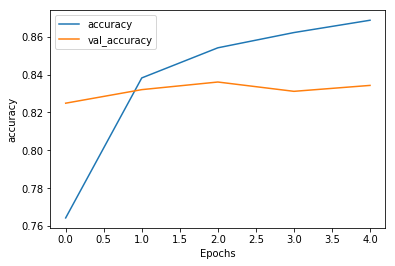

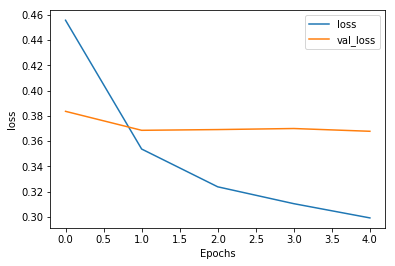

In [15]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [0]:
#model.save("test.h5")